In [25]:
#https://www.kaggle.com/harangdev/feature-selection
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt

import warnings
import gc
warnings.filterwarnings("ignore")

In [26]:
data = pd.read_csv('../BigContest/AllMergeJamDonny.csv', index_col='acc_id')
data= data.drop(columns='Unnamed: 0')
df= data
# test = pd.read_csv('../SHAP/Allmerge_test_notinlabel.csv', index_col='acc_id')
# df = pd.concat([data, test])

In [27]:
df.head()

,playtime,npc_kill,solo_exp,party_exp,quest_exp,boss_monster,death,revive,exp_recovery,fishing,...,pledge_combat_cnt,random_attacker_cnt_plg,random_defender_cnt_plg,same_pledge_cnt_plg,temp_cnt_plg,etc_cnt_plg,combat_play_time,non_combat_play_time,survival_time,amount_spent
acc_id,,,,,,,,,,,,,,,,,,,,,
27835,9.978209,12.747726,0.130439,0.000000,0.022510,1.0,0.245370,0.246819,0.000000,1.199558,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.0,0.002559
12351,82.013292,37.056629,0.532874,0.039412,0.016449,7.0,0.981479,0.987277,0.000000,39.579596,...,3.782773,2.804439,1.867763,11.316867,11.085888,3.106572,21.074054,0.019254,64.0,0.120154
125437,40.050302,13.461275,0.176408,0.015579,0.133937,7.0,12.023119,12.094146,0.000000,23.991864,...,8.097357,18.106920,3.218910,43.764446,27.291721,35.660301,79.411095,0.000000,55.0,0.182593
104483,61.668175,48.607348,0.243065,0.001153,0.006926,2.0,1.472219,1.480916,31.830496,2.044150,...,0.369717,4.109830,3.195066,7.426694,17.930793,1.802598,36.301640,0.000000,64.0,0.016241
4704,26.002596,17.106278,0.432320,0.545593,0.226839,15.0,0.736109,0.740458,0.000000,9.279142,...,0.100853,0.439763,1.502158,1.094111,7.960085,1.635964,7.578028,0.042944,20.0,0.226396


In [28]:
df.dtypes

playtime                   float64
npc_kill                   float64
solo_exp                   float64
party_exp                  float64
quest_exp                  float64
boss_monster               float64
death                      float64
revive                     float64
exp_recovery               float64
fishing                    float64
private_shop               float64
game_money_change          float64
enchant_count              float64
level                      float64
pledge_cnt                 float64
random_attacker_cnt        float64
random_defender_cnt        float64
temp_cnt                   float64
same_pledge_cnt            float64
etc_cnt                    float64
num_opponent               float64
amount_spent_pay           float64
sell_item_cnt              float64
buy_item_cnt               float64
play_char_cnt              float64
combat_char_cnt            float64
pledge_combat_cnt          float64
random_attacker_cnt_plg    float64
random_defender_cnt_

In [29]:
def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred)-np.expm1(true))**2))

def evaluate(x_data, y_data):
    model = LGBMRegressor(objective='regression', num_iterations=10**5)
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
    model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
    val_pred = model.predict(x_val)
    score = rmse_expm1(val_pred, y_val)
    return score

def rfe(x_data, y_data, method, ratio=0.9, min_feats=40):
    feats = x_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        x_train, x_val, y_train, y_val = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
        val_pred = model.predict(x_val)
        score = rmse_expm1(val_pred, y_val)
        n_feats = len(feats)
        print(n_feats, score)
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

feats = [col for col in data.columns if (col != 'survival_time') & (col != 'amount_spent')]
len(feats) 

34

In [30]:
feats

['playtime',
 'npc_kill',
 'solo_exp',
 'party_exp',
 'quest_exp',
 'boss_monster',
 'death',
 'revive',
 'exp_recovery',
 'fishing',
 'private_shop',
 'game_money_change',
 'enchant_count',
 'level',
 'pledge_cnt',
 'random_attacker_cnt',
 'random_defender_cnt',
 'temp_cnt',
 'same_pledge_cnt',
 'etc_cnt',
 'num_opponent',
 'amount_spent_pay',
 'sell_item_cnt',
 'buy_item_cnt',
 'play_char_cnt',
 'combat_char_cnt',
 'pledge_combat_cnt',
 'random_attacker_cnt_plg',
 'random_defender_cnt_plg',
 'same_pledge_cnt_plg',
 'temp_cnt_plg',
 'etc_cnt_plg',
 'combat_play_time',
 'non_combat_play_time']

In [31]:
model = LGBMRegressor(objective='regression', num_iterations=10**5)
x_data = data[feats]
y_data = data['amount_spent']
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, random_state=0)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=False)
val_pred = model.predict(x_val)
score = rmse_expm1(val_pred, y_val)
score

-1308243657027193.5

In [32]:
%%time
basic_archive = rfe(x_data, y_data, 'basic')

34 -1308243657027193.5
Wall time: 575 ms


In [33]:
feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp.iloc[:i].index], data['amount_spent']))

40 -1308243657027193.5
45 -1308243657027193.5
50 -1308243657027193.5
55 -1308243657027193.5
60 -1308243657027193.5
65 -1308243657027193.5
70 -1308243657027193.5
75 -1308243657027193.5
80 -1308243657027193.5
85 -1308243657027193.5


In [34]:
%%time
perm_archive = rfe(x_data, y_data, 'perm')

34 -1308243657027193.5
Wall time: 5.26 s


In [35]:
perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
perm_feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
eli5.show_weights(perm)

Weight,Feature
0.6592 ± 0.0763,x0
0.1697 ± 0.0507,x21
0.0924 ± 0.0558,x22
0.0540 ± 0.0308,x11
0.0272 ± 0.0058,x2
0.0200 ± 0.0017,x20
0.0167 ± 0.0065,x4
0.0159 ± 0.0037,x23
0.0152 ± 0.0062,x28
0.0151 ± 0.0030,x9


In [36]:
for i in range(40, 90, 5):
    print(i, evaluate(data[perm_feat_imp.iloc[:i].index], data['amount_spent']))

40 -1308243657027193.5
45 -1308243657027193.5
50 -1308243657027193.5
55 -1308243657027193.5
60 -1308243657027193.5
65 -1308243657027193.5
70 -1308243657027193.5
75 -1308243657027193.5
80 -1308243657027193.5
85 -1308243657027193.5


In [37]:
%%time
shap_archive = rfe(x_data, y_data, 'shap')

34 -1308243657027193.5
Wall time: 2.76 s


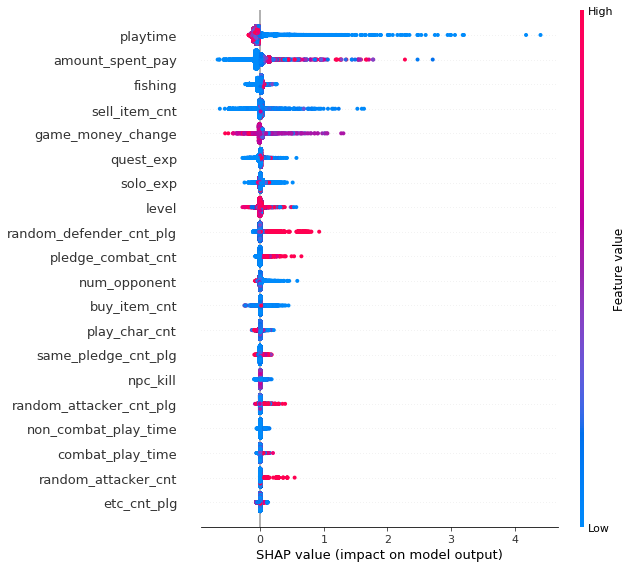

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
shap.summary_plot(shap_values, x_data)

In [39]:
for i in range(40, 90, 5):
    print(i, evaluate(data[shap_feat_imp.iloc[:i].index], data['amount_spent']))

40 -1308243657027193.5
45 -1308243657027193.5
50 -1308243657027193.5
55 -1308243657027193.5
60 -1308243657027193.5
65 -1308243657027193.5
70 -1308243657027193.5
75 -1308243657027193.5
80 -1308243657027193.5
85 -1308243657027193.5


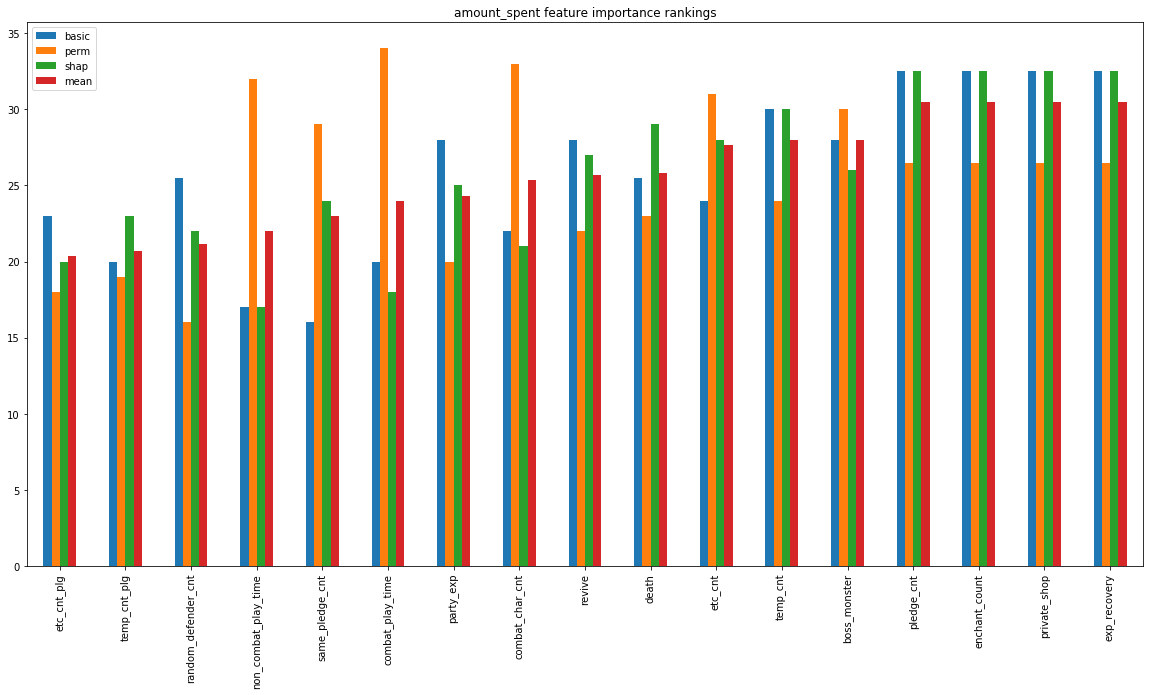

In [40]:
feat_imp_archive = pd.DataFrame(index=feats, columns=['basic', 'perm', 'shap', 'mean'])
feat_imp_archive['basic'] = feat_imp.rank(ascending=False)
feat_imp_archive['perm'] = perm_feat_imp.rank(ascending=False)
feat_imp_archive['shap'] = shap_feat_imp.rank(ascending=False)
feat_imp_archive['mean'] = feat_imp_archive[['basic', 'perm', 'shap']].mean(axis=1)
feat_imp_archive = feat_imp_archive.sort_values('mean')
feat_imp_archive[feat_imp_archive['mean']>20].plot(kind='bar', figsize=(20, 10), title='amount_spent feature importance rankings');

In [41]:
feat_imp_archive.sort_values('mean',ascending=False)

,basic,perm,shap,mean
exp_recovery,32.5,26.5,32.5,30.500000
private_shop,32.5,26.5,32.5,30.500000
enchant_count,32.5,26.5,32.5,30.500000
pledge_cnt,32.5,26.5,32.5,30.500000
boss_monster,28.0,30.0,26.0,28.000000
temp_cnt,30.0,24.0,30.0,28.000000
etc_cnt,24.0,31.0,28.0,27.666667
death,25.5,23.0,29.0,25.833333
revive,28.0,22.0,27.0,25.666667
combat_char_cnt,22.0,33.0,21.0,25.333333


In [42]:
feat = feat_imp_archive.sort_values('mean',ascending=False)

In [43]:
list(feat.index)

['exp_recovery',
 'private_shop',
 'enchant_count',
 'pledge_cnt',
 'boss_monster',
 'temp_cnt',
 'etc_cnt',
 'death',
 'revive',
 'combat_char_cnt',
 'party_exp',
 'combat_play_time',
 'same_pledge_cnt',
 'non_combat_play_time',
 'random_defender_cnt',
 'temp_cnt_plg',
 'etc_cnt_plg',
 'random_attacker_cnt',
 'same_pledge_cnt_plg',
 'random_attacker_cnt_plg',
 'npc_kill',
 'pledge_combat_cnt',
 'play_char_cnt',
 'num_opponent',
 'buy_item_cnt',
 'level',
 'fishing',
 'random_defender_cnt_plg',
 'quest_exp',
 'solo_exp',
 'sell_item_cnt',
 'game_money_change',
 'amount_spent_pay',
 'playtime']

In [51]:
len(list(feat.index))

34

In [44]:
jam = list(feat.index[:28])

In [45]:
rac = [ 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'boss_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change',
       'enchant_count', 'level', 'pledge_cnt', 'random_attacker_cnt',
       'random_defender_cnt', 'temp_cnt', 'same_pledge_cnt', 'etc_cnt',
       'num_opponent',  'sell_item_cnt','amount_spent_pay', 'buy_item_cnt',
       'play_char_cnt', 'combat_char_cnt', 'pledge_combat_cnt',
       'random_attacker_cnt_plg', 'random_defender_cnt_plg',
       'same_pledge_cnt_plg', 'temp_cnt_plg', 'etc_cnt_plg',
       'combat_play_time', 'non_combat_play_time']

In [50]:
len(rac)

34

In [46]:
jam

['exp_recovery',
 'private_shop',
 'enchant_count',
 'pledge_cnt',
 'boss_monster',
 'temp_cnt',
 'etc_cnt',
 'death',
 'revive',
 'combat_char_cnt',
 'party_exp',
 'combat_play_time',
 'same_pledge_cnt',
 'non_combat_play_time',
 'random_defender_cnt',
 'temp_cnt_plg',
 'etc_cnt_plg',
 'random_attacker_cnt',
 'same_pledge_cnt_plg',
 'random_attacker_cnt_plg',
 'npc_kill',
 'pledge_combat_cnt',
 'play_char_cnt',
 'num_opponent',
 'buy_item_cnt',
 'level',
 'fishing',
 'random_defender_cnt_plg']

In [47]:
set(jam).intersection(set(rac))

{'boss_monster',
 'buy_item_cnt',
 'combat_char_cnt',
 'combat_play_time',
 'death',
 'enchant_count',
 'etc_cnt',
 'etc_cnt_plg',
 'exp_recovery',
 'fishing',
 'level',
 'non_combat_play_time',
 'npc_kill',
 'num_opponent',
 'party_exp',
 'play_char_cnt',
 'pledge_cnt',
 'pledge_combat_cnt',
 'private_shop',
 'random_attacker_cnt',
 'random_attacker_cnt_plg',
 'random_defender_cnt',
 'random_defender_cnt_plg',
 'revive',
 'same_pledge_cnt',
 'same_pledge_cnt_plg',
 'temp_cnt',
 'temp_cnt_plg'}

In [48]:
len(set(jam).intersection(set(rac)))

28

In [49]:
for i in range(40, 90, 5):
    print(i, evaluate(data[feat_imp_archive.iloc[:i].index], data['amount_spent']))

40 -1308243657027193.5
45 -1308243657027193.5
50 -1308243657027193.5
55 -1308243657027193.5
60 -1308243657027193.5
65 -1308243657027193.5
70 -1308243657027193.5
75 -1308243657027193.5
80 -1308243657027193.5
85 -1308243657027193.5


## Boruta

In [26]:
%%time
rf = RandomForestRegressor(n_jobs=-1, n_estimators=200, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=0)
feat_selector.fit(data[feats].values, data['amount_spent'].values)

Wall time: 2min 17s


BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                         max_depth=5, max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=48, n_jobs=-1,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x000001956DBF9798>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_state=<mtrand.RandomState object at 0x000001956DBF9798>,
         t

In [27]:
evaluate(data[np.array(feats)[feat_selector.support_]], data['amount_spent'])

-1308243657027193.5

In [28]:
# gpu_test.py

import sys
import numpy as np
import tensorflow as tf
from datetime import datetime

shape = (int(10000), int(10000))

# with tf.device("/cpu:0"):
with tf.device("/gpu:0"):
    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

startTime = datetime.now()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    result = session.run(sum_operation)
    print(result)

print("\n" * 2)
print("Time taken:", datetime.now() - startTime)
print("\n" * 2)

250014040000.0



Time taken: 0:00:39.292051



